In [1]:
import os
import sys
import dotenv

from IPython.utils import io

import eolearn
from eolearn.core import (
    FeatureType,
    linearly_connect_tasks,
    EOWorkflow,
    OutputTask,
    LoadTask,
)
from eolearn.ml_tools import TrainTestSplitTask

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from lightgbm import log_evaluation, early_stopping
import optuna.integration.lightgbm as lgb
from sklearn.metrics import mean_squared_error
import dalex as dx

root_dir = os.path.abspath('../')
if not root_dir in sys.path: sys.path.append(root_dir)

import eolearn_extras as eolx

from sdb_utils.ml_utils import (
    get_X_y_for_split,
    SplitType,
    create_sdb_estimation,
    get_masked_map,
    create_train_val_set,
    write_optuna_capture_to_logs,
)

dotenv.load_dotenv()
data_root_path = os.environ.get('data_root')

In [2]:
bahamas_eop_path = os.path.abspath(
    os.path.join(data_root_path, 'eopatches', 'bahamas_sentinel_merged')
)
load_bahamas_eop = LoadTask(bahamas_eop_path)

data_mask_feature = (FeatureType.MASK_TIMELESS, 'bathy_data_mask')
train_test_mask_feature = (FeatureType.MASK_TIMELESS, 'train_test_split')

train_test_split_task = TrainTestSplitTask(
    input_feature=data_mask_feature,
    output_feature=train_test_mask_feature,
    bins=[0.025, 0.05],
    split_type=eolearn.ml_tools.train_test_split.TrainTestSplitType.PER_PIXEL,
)

valid_train_test_data_mask_task = eolx.ml_util.AddValidTrainTestMasks(
    train_test_maks_feature=train_test_mask_feature,
    valid_data_mask_feature=data_mask_feature
)

tt_wf_output_label = 'tt_wf_output'
output_task = OutputTask(tt_wf_output_label)

nodes = linearly_connect_tasks(
    load_bahamas_eop,
    train_test_split_task,
    valid_train_test_data_mask_task,
    output_task,
)
read_merge_wf = EOWorkflow(nodes)

train_test_split_ref = [node for node in nodes if node.name == 'TrainTestSplitTask'][0]
read_merge_wf_res = read_merge_wf.execute(
    input_kwargs={
        train_test_split_ref: {'seed': 42}
    }
)

train_test_eop = read_merge_wf_res.outputs[tt_wf_output_label]
train_test_eop

EOPatch(
  data={
    L1C_data: numpy.ndarray(shape=(1, 894, 1946, 13), dtype=uint16)
    L2A_data: numpy.ndarray(shape=(1, 894, 1946, 12), dtype=float32)
    L2W_data: numpy.ndarray(shape=(1, 894, 1946, 11), dtype=float32)
  }
  data_timeless={
    bathy_data: numpy.ndarray(shape=(894, 1946, 1), dtype=float64)
  }
  mask_timeless={
    bathy_data_mask: numpy.ndarray(shape=(894, 1946, 1), dtype=uint8)
    test_split_valid: numpy.ndarray(shape=(894, 1946, 1), dtype=int32)
    train_split_valid: numpy.ndarray(shape=(894, 1946, 1), dtype=int32)
    train_test_split: numpy.ndarray(shape=(894, 1946, 1), dtype=int64)
    validation_split_valid: numpy.ndarray(shape=(894, 1946, 1), dtype=int32)
  }
  meta_info={
    test_count: 1653194
    test_perc: 0.950262225502436
    train_count: 43427
    train_perc: 0.02496200546753393
    validation_count: 43103
    validation_perc: 0.02477576903003005
  }
  bbox=BBox(((758523.8845987623, 2793786.7214435483), (777983.8845987623, 2802726.7214435483)), c

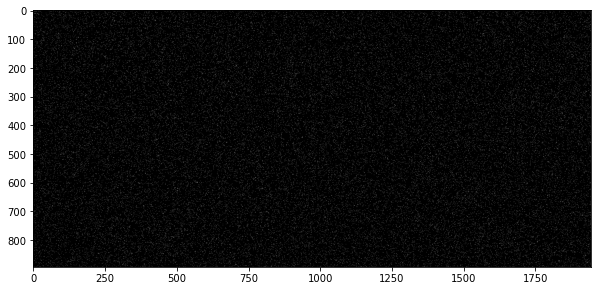

In [3]:
eolx.visualization.plot_single_band(train_test_eop, (FeatureType.MASK_TIMELESS, 'train_split_valid'), colorbar=False, stretch=False)
plt.show()

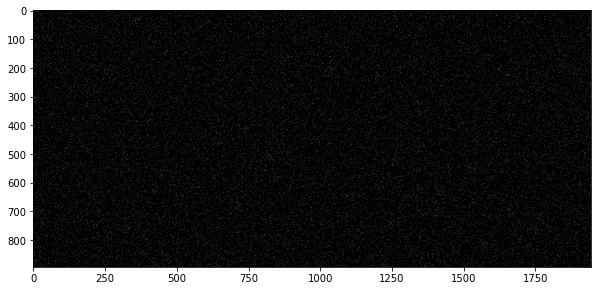

In [4]:
eolx.visualization.plot_single_band(train_test_eop, (FeatureType.MASK_TIMELESS, 'validation_split_valid'), colorbar=False, stretch=False)
plt.show()

### L2A Experiment

In [5]:
params = {
    'objective': 'regression',
    'metric': 'mean_squared_error',
    'seed': 42,
}

(train_ds, val_ds) = create_train_val_set(train_test_eop, (FeatureType.DATA, 'L2A_data'))

with io.capture_output() as capture:
    model_l2a = lgb.train(
        params,
        train_ds,
        valid_sets=val_ds,
        callbacks=[log_evaluation(100), early_stopping(100)],
        optuna_seed=42,
    )

write_optuna_capture_to_logs('../optuna_logs', capture)

[I 2022-05-04 12:33:37,442] A new study created in memory with name: no-name-270f233d-8fd4-4654-bcc5-35492eb5b44e
[I 2022-05-04 12:33:38,968] Trial 0 finished with value: 0.01263472764465479 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.01263472764465479.
[I 2022-05-04 12:33:40,743] Trial 1 finished with value: 0.01263472764465479 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.01263472764465479.
[I 2022-05-04 12:33:42,770] Trial 2 finished with value: 0.012590188486313152 and parameters: {'feature_fraction': 0.7}. Best is trial 2 with value: 0.012590188486313152.
[I 2022-05-04 12:33:44,430] Trial 3 finished with value: 0.012590188486313152 and parameters: {'feature_fraction': 0.8}. Best is trial 2 with value: 0.012590188486313152.
[I 2022-05-04 12:33:46,192] Trial 4 finished with value: 0.012528282077987495 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 4 with value: 0.012528282077987495.
[I 2022-05-04 12:33:

In [7]:
best_params = model_l2a.params
best_params

{'objective': 'regression',
 'metric': 'l2',
 'seed': 42,
 'feature_pre_filter': False,
 'lambda_l1': 0.0009779587236218158,
 'lambda_l2': 0.1706087547564104,
 'num_leaves': 252,
 'feature_fraction': 0.8999999999999999,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 25,
 'num_iterations': 1000,
 'early_stopping_round': None}

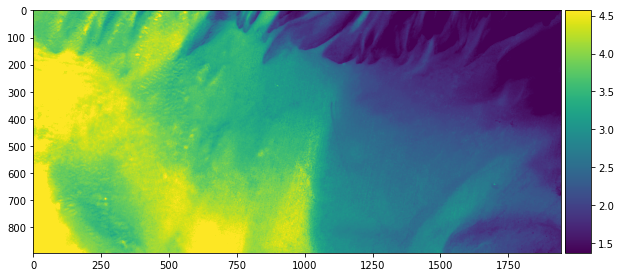

In [8]:
X_all, y_all = get_X_y_for_split(
    train_test_eop,
    split_type=SplitType.All,
    data_feature=(FeatureType.DATA, 'L2A_data'),
    label_feature=(FeatureType.DATA_TIMELESS, 'bathy_data'),
)

l2a_sdb_estimation_values, l2a_sdb_estimation_map = create_sdb_estimation(train_test_eop, model_l2a, X_all)
eolx.visualization.plot_ndarray_band(l2a_sdb_estimation_map, cmap='viridis')
plt.show()

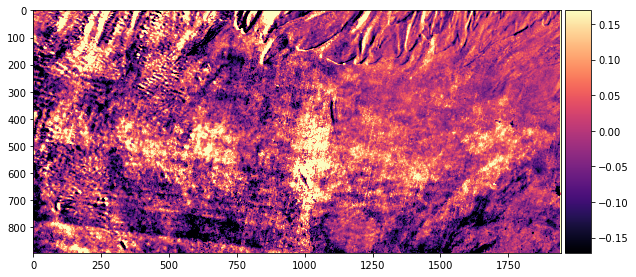

In [9]:
masked_bathy_data = get_masked_map(
    train_test_eop,
    (FeatureType.DATA_TIMELESS, 'bathy_data'),
    data_mask_feature
)
l2a_sdb_errors = l2a_sdb_estimation_map - masked_bathy_data
eolx.visualization.plot_ndarray_band(l2a_sdb_errors, cmap='magma')
plt.show()

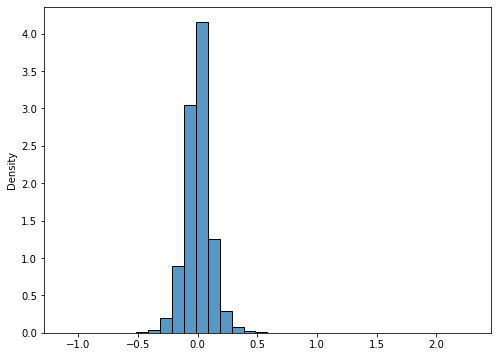

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))
l2a_sdb_residuals = l2a_sdb_estimation_values - y_all
sns.histplot(l2a_sdb_residuals, binwidth=0.1, stat='density', ax=ax)
plt.show()

In [11]:
exp_lgbm_l2a = dx.Explainer(model_l2a, val_ds.data, val_ds.label, label='lgbm_tuned_l2a', verbose=False)
exp_lgbm_l2a.model_performance()

,mse,rmse,r2,mae,mad
lgbm_tuned_l2a,0.012333,0.111056,0.988641,0.078241,0.057226


### L1C Experiment

In [13]:
(train_ds, val_ds) = create_train_val_set(train_test_eop, (FeatureType.DATA, 'L1C_data'))

with io.capture_output() as capture:
    model_l1c = lgb.train(
        params,
        train_ds,
        valid_sets=val_ds,
        callbacks=[log_evaluation(100), early_stopping(100)],
        optuna_seed=42,
    )

write_optuna_capture_to_logs('../optuna_logs', capture)

[I 2022-05-04 12:39:00,652] A new study created in memory with name: no-name-61f92add-61d9-49a7-a520-12475c4016bc
[I 2022-05-04 12:39:02,244] Trial 0 finished with value: 0.010104105857093128 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 0.010104105857093128.
[I 2022-05-04 12:39:03,953] Trial 1 finished with value: 0.010075773208517337 and parameters: {'feature_fraction': 0.8}. Best is trial 1 with value: 0.010075773208517337.
[I 2022-05-04 12:39:06,064] Trial 2 finished with value: 0.010009634035520501 and parameters: {'feature_fraction': 1.0}. Best is trial 2 with value: 0.010009634035520501.
[I 2022-05-04 12:39:07,864] Trial 3 finished with value: 0.010009634035520501 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 2 with value: 0.010009634035520501.
[I 2022-05-04 12:39:09,531] Trial 4 finished with value: 0.010009634035520501 and parameters: {'feature_fraction': 0.5}. Best is trial 2 with value: 0.010009634035520501.
[I 2022-05-04 12

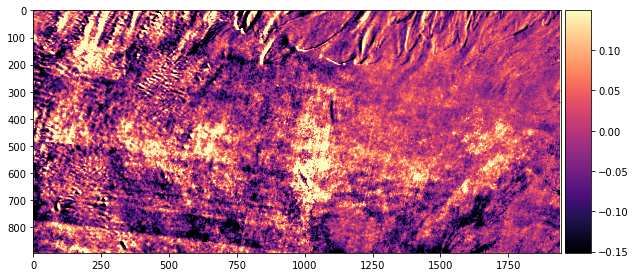

In [15]:
X_all, y_all = get_X_y_for_split(
    train_test_eop,
    split_type=SplitType.All,
    data_feature=(FeatureType.DATA, 'L1C_data'),
    label_feature=(FeatureType.DATA_TIMELESS, 'bathy_data'),
)

l1c_sdb_estimation_values, l1c_sdb_estimation_map = create_sdb_estimation(train_test_eop, model_l1c, X_all)

masked_bathy_data = get_masked_map(
    train_test_eop,
    (FeatureType.DATA_TIMELESS, 'bathy_data'),
    data_mask_feature
)
l1c_sdb_errors = l1c_sdb_estimation_map - masked_bathy_data
eolx.visualization.plot_ndarray_band(l1c_sdb_errors, cmap='magma')
plt.show()

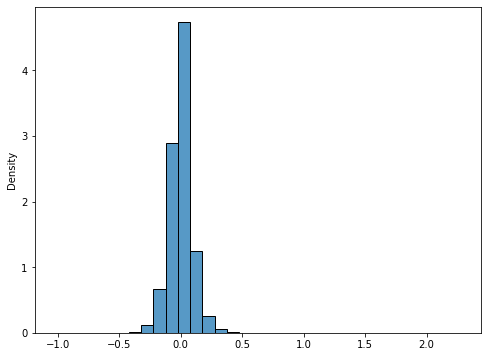

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))
l1c_sdb_residuals = l1c_sdb_estimation_values - y_all
sns.histplot(l1c_sdb_residuals, binwidth=0.1, stat='density', ax=ax)
plt.show()

In [17]:
exp_lgbm_l1c = dx.Explainer(model_l1c, val_ds.data, val_ds.label, label='lgbm_tuned_l1c', verbose=False)
exp_lgbm_l1c.model_performance()

,mse,rmse,r2,mae,mad
lgbm_tuned_l1c,0.009825,0.099123,0.990951,0.068839,0.04978


### Acolite Experiment

In [19]:
(train_ds, val_ds) = create_train_val_set(train_test_eop, (FeatureType.DATA, 'L2W_data'))

with io.capture_output() as capture:
    model_acolite = lgb.train(
        params,
        train_ds,
        valid_sets=val_ds,
        callbacks=[log_evaluation(100), early_stopping(100)],
        optuna_seed=42,
    )

write_optuna_capture_to_logs('../optuna_logs', capture)

[I 2022-05-04 12:50:39,335] A new study created in memory with name: no-name-c23d85e7-9f38-4e70-9e9b-2dcab42ff23b
[I 2022-05-04 12:50:40,556] Trial 0 finished with value: 0.011997590289485965 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.011997590289485965.
[I 2022-05-04 12:50:42,145] Trial 1 finished with value: 0.011816734214874329 and parameters: {'feature_fraction': 0.8}. Best is trial 1 with value: 0.011816734214874329.
[I 2022-05-04 12:50:43,702] Trial 2 finished with value: 0.011816734214874329 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 1 with value: 0.011816734214874329.
[I 2022-05-04 12:50:45,299] Trial 3 finished with value: 0.011766405127427186 and parameters: {'feature_fraction': 0.6}. Best is trial 3 with value: 0.011766405127427186.
[I 2022-05-04 12:50:46,963] Trial 4 finished with value: 0.011686227316284367 and parameters: {'feature_fraction': 0.5}. Best is trial 4 with value: 0.011686227316284367.
[I 2022-05-04 12

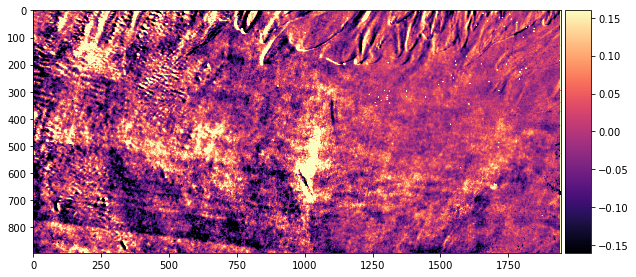

In [20]:
X_all, y_all = get_X_y_for_split(
    train_test_eop,
    split_type=SplitType.All,
    data_feature=(FeatureType.DATA, 'L2W_data'),
    label_feature=(FeatureType.DATA_TIMELESS, 'bathy_data'),
)

acolite_sdb_estimation_values, acolite_sdb_estimation_map = create_sdb_estimation(train_test_eop, model_acolite, X_all)

masked_bathy_data = get_masked_map(
    train_test_eop,
    (FeatureType.DATA_TIMELESS, 'bathy_data'),
    data_mask_feature
)
acolite_sdb_errors = acolite_sdb_estimation_map - masked_bathy_data
eolx.visualization.plot_ndarray_band(acolite_sdb_errors, cmap='magma')
plt.show()

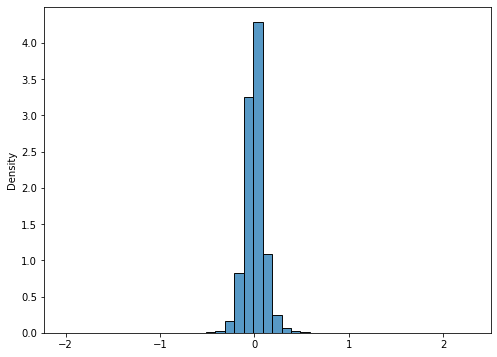

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))
acolite_sdb_residuals = acolite_sdb_estimation_values - y_all
sns.histplot(acolite_sdb_residuals, binwidth=0.1, stat='density', ax=ax)
plt.show()

In [22]:
exp_lgbm_acolite = dx.Explainer(model_acolite, val_ds.data, val_ds.label, label='lgbm_tuned_acolite', verbose=False)
exp_lgbm_acolite.model_performance()

,mse,rmse,r2,mae,mad
lgbm_tuned_acolite,0.01132,0.106396,0.989574,0.073145,0.051888


### Evaluation

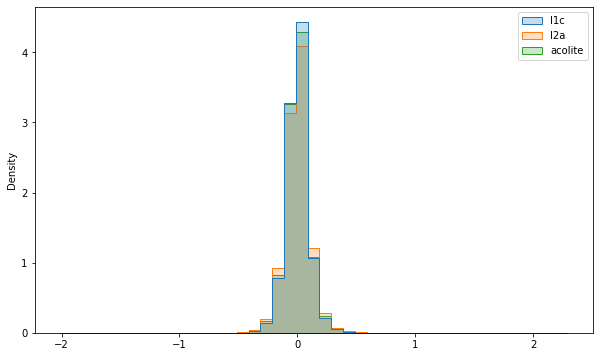

In [23]:
residuals_df = pd.DataFrame({
    'l1c': l1c_sdb_residuals,
    'l2a': l2a_sdb_residuals,
    'acolite': acolite_sdb_residuals
})

plt.figure(figsize=(10, 6))
sns.histplot(residuals_df, binwidth=0.1, stat='density', element='step', common_norm=False)
plt.show()

In [24]:
exp_list = [exp_lgbm_l1c, exp_lgbm_l2a, exp_lgbm_acolite]
pd.concat([exp.model_performance().result for exp in exp_list])

,mse,rmse,r2,mae,mad
lgbm_tuned_l1c,0.009825,0.099123,0.990951,0.068839,0.049780
lgbm_tuned_l2a,0.012333,0.111056,0.988641,0.078241,0.057226
lgbm_tuned_acolite,0.011320,0.106396,0.989574,0.073145,0.051888


In [25]:
exp_list[0].model_parts().plot([exp.model_parts() for exp in exp_list[1:]])